## Supervised Learning

## Project: Finding Donors for *CharityML* - Final Product

## Show workspace status

In [ ]:
import nltk
import sklearn
from platform import python_version


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The python version is {}.'.format(python_version()))

The nltk version is 3.7.
The scikit-learn version is 1.0.2.
The python version is 3.7.13.


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import required libraries

In [ ]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import fbeta_score , accuracy_score ,roc_auc_score
from sklearn.ensemble import  GradientBoostingClassifier
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image


warnings.simplefilter(action="ignore", category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read train data

In [ ]:
df = pd.read_csv("/content/census.csv")
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Split The data 


In [ ]:
income_raw = df['income']
features_raw = df.drop('income', axis = 1)
income = (income_raw == ">50K").astype(int)

In [ ]:
y = (income_raw == ">50K").astype(int)
X = features_raw


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)


## Bulid the model

In [ ]:
GradientBoostingClassifier()

GradientBoostingClassifier()

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    GradientBoostingClassifier(max_depth=4 , n_estimators=300,min_samples_split=30)    
)

model.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education_level',
                                      'marital-status', 'occupation',
                                      'relationship', 'race', 'sex',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping':  Private             1
 Self-emp-not-inc    2
 Self-emp-inc        3
 State-gov           4
 Local-gov           5
 Federal-gov         6
 Without-pay         7
NaN                 -2
dtype: int64},
                                         {'col': 'education_level',
                                          'da...
 Thailand                      19
 Cuba                          20
 El-Salvador                   21
 England                       22
 China                         23
 Hong                          

## Enjoy Beauty of Trees

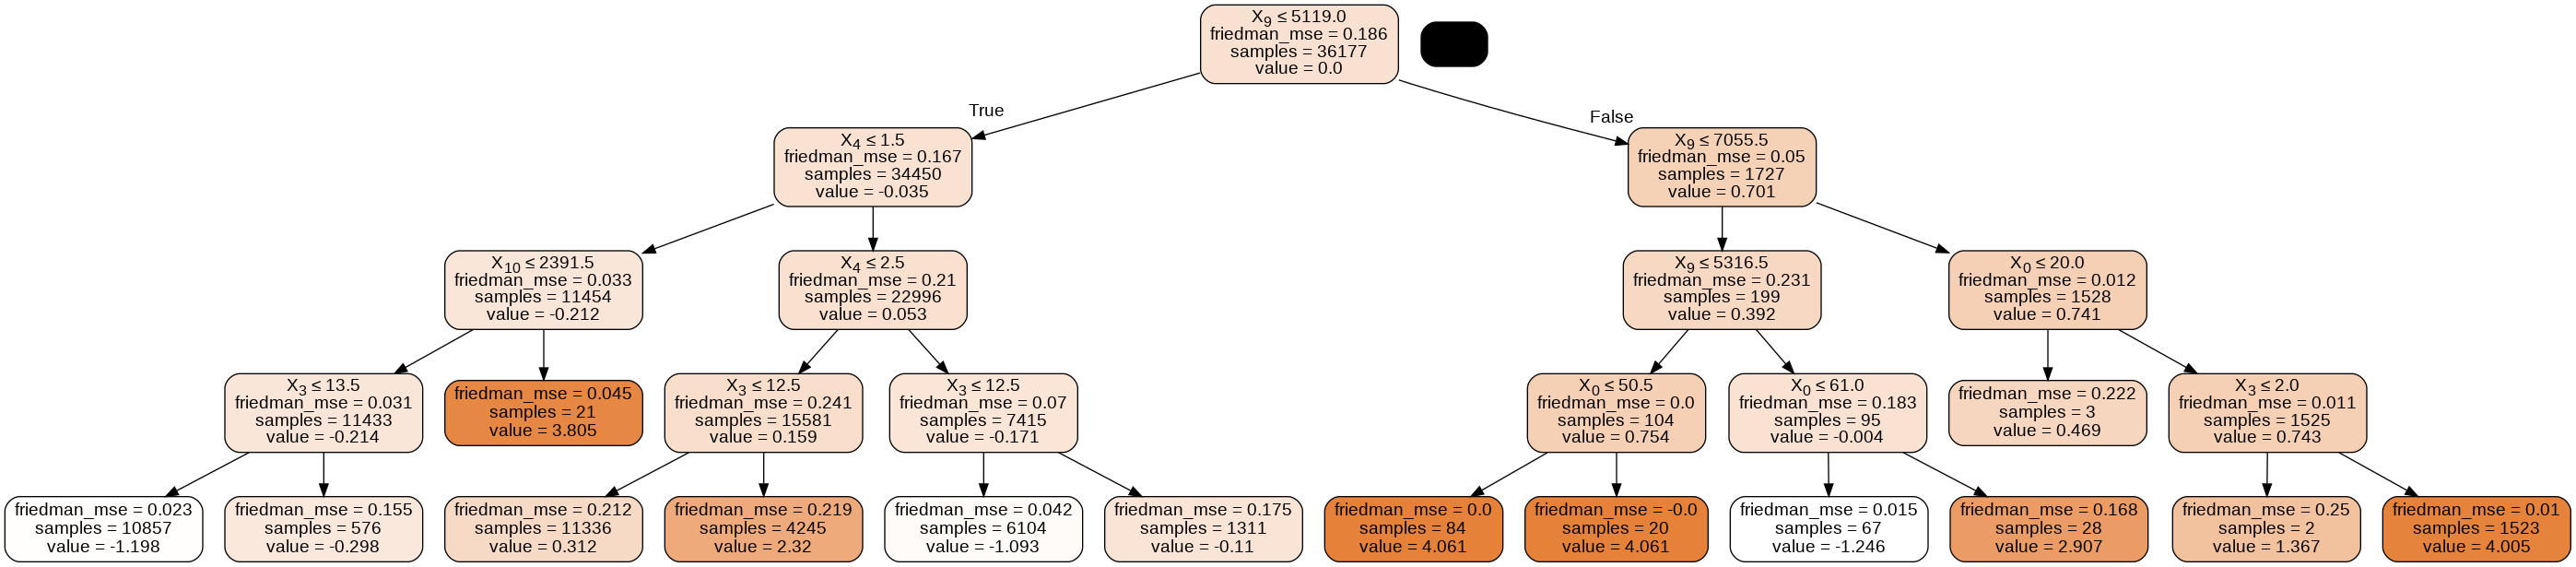

In [ ]:
# Get one tree of the forest
tree_1 = model.named_steps["gradientboostingclassifier"].estimators_[0][0]


# show me some Beauty
plot_tree = export_graphviz(
    tree_1,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
)
show_tree = graph_from_dot_data(plot_tree)
Image(show_tree.create_png())

In [ ]:
y_train_pred = model.predict(X_train)

train_acc = round(accuracy_score(y_train , y_train_pred),2)

train_fbeta = round(fbeta_score(y_train , y_train_pred ,  beta =.5),2)

probs_train = model.predict_proba(X_train)[:, 1]

print(f"Accuracy score train: {train_acc}.")

print(f"fbeta_score train : {train_fbeta}.")

print(f"ROC score train:{round(roc_auc_score(y_train, probs_train),2)}.")


Accuracy score train: 0.88.
fbeta_score train : 0.78.
ROC score train:0.94.


## Feature Importance

In [ ]:
features = X_train.columns
importances = model.named_steps["gradientboostingclassifier"].feature_importances_

In [ ]:
feat_imp = pd.Series(importances , index=features).sort_values()
feat_imp.tail()

age               0.066859
capital-loss      0.079350
education-num     0.171936
capital-gain      0.279330
marital-status    0.289615
dtype: float64

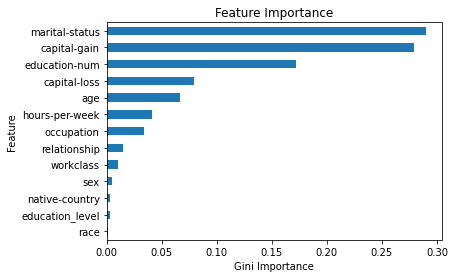

In [ ]:
# Create horizontal bar chart for Feature Importance
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

## Feature Selection

In [ ]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]
model.fit(X_train_reduced,y_train)

# Make new predictions
reduced_predictions = model.predict(X_test_reduced)

print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))


Final Model trained on reduced data
------
Accuracy on testing data: 0.8598
F-score on testing data: 0.7464


## Create estimation function

In [ ]:
def make_estimation(age ,capital_loss,education_num,capital_gain,marital_status ):
    """
    Estimate whether the person is a potential donor or not based on :
    
    Args:
        age (int): The age of the person.
        capital_loss (float): The amount of the investment Loss.
        education_num (int) : The education level. 
        capital_gain (int): The amount of the investment profit.
        marital_status (sting): The marital status.
        
    Returns:
        A Donor if estimation == 1,
        Not a Donor if estimation == 0
    """

    data ={
        "age": age ,
        "capital-loss": capital_loss,
        "education-num ":education_num,
        "capital-gain " :capital_gain,
        "marital-status":marital_status     
    }
    
    df = pd.DataFrame(data,index=[0])
    estimation = model.predict(df).round(2)[0]
    
    if estimation == 1 :
        print(f"Estimation: A Donor ") 
    else:
        print(f"Estimation: Not a Donor") 

## Simple Dashboard for easy use



In [ ]:
interact(
    make_estimation,
    age=IntSlider(
        min=X_train_reduced["age"].min(),
        max=X_train_reduced["age"].max(),
        value=X_train_reduced["age"].mean(),
    ),
    capital_loss=FloatSlider(
        min=X_train_reduced["capital-loss"].min(),
        max=X_train_reduced["capital-loss"].max(),
        step=0.01,
        value=X_train_reduced["capital-loss"].mean(),
    ),
    education_num=IntSlider(
        min=X_train_reduced["education-num"].min(),
        max=X_train_reduced["education-num"].max(),
        value=X_train_reduced["education-num"].mean()
    ),
    capital_gain = FloatSlider(
        min=X_train_reduced["capital-gain"].min(),
        max=X_train_reduced["capital-gain"].max(),
        step=0.01,
        value=X_train_reduced["capital-gain"].mean(),
    ),
    marital_status =Dropdown(options=sorted(X_train_reduced["marital-status"].unique()))
);

interactive(children=(IntSlider(value=38, description='age', max=90, min=17), FloatSlider(value=87.18296155015…